In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_augmentation import random_transform


from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPooling2D, Reshape, Flatten, Input, merge, subtract
from keras import backend as K

Using TensorFlow backend.


In [2]:
resize_shape = (224, 224, 3)

In [3]:
data = pd.read_csv("data/train.csv")

In [4]:
#For now, we remove new_whale
data = data[data['Id'] != 'new_whale'].reset_index(drop=True)

In [5]:
len(data)

9040

# Look at example 

In [6]:
data.head(10)

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
7,0035632e.jpg,w_3d0bc7a
8,0037e7d3.jpg,w_50db782
9,00389cd7.jpg,w_2863d51


In [7]:
from PIL import Image
image = Image.open('data/train/00022e1a.jpg')

In [8]:
np.array(image).shape

(500, 699)

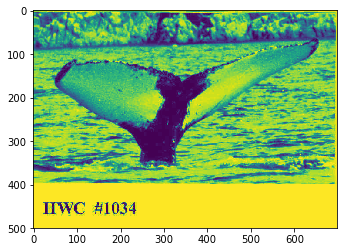

In [9]:
plt.imshow(image)
plt.show()

In [10]:
np.array(image).shape

(500, 699)

In [11]:
new_image = np.stack([image]*3,axis=2)

In [12]:
np.array(new_image).shape

(500, 699, 3)

In [13]:
# gray = np.mean(image, -1)

In [14]:
# gray.shape

In [15]:
# plt.imshow(random_transform(gray),cmap='gray')
# plt.show()

# All images (if small) can be held in memory.

In [16]:
file_list = data['Image']

In [17]:
def get_image(file, shape=(resize_shape[0],resize_shape[1])):
    image = Image.open('data/train/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 2:
        image = np.stack([image]*3,axis=2) 
    return image

In [18]:
image_list = [get_image(f) for f in file_list]

In [19]:
length_list = [len(image.shape) for image in image_list]

In [20]:
file_list[0]

'00022e1a.jpg'

In [21]:
data['image_array'] = image_list

In [22]:
data.head(4)

,Image,Id,image_array
0,00022e1a.jpg,w_e15442c,"[[[199, 199, 199], [191, 191, 191], [192, 192,..."
1,000466c4.jpg,w_1287fbc,"[[[198, 191, 185], [198, 191, 185], [194, 187,..."
2,00087b01.jpg,w_da2efe0,"[[[180, 180, 180], [177, 177, 177], [181, 181,..."
3,001296d5.jpg,w_19e5482,"[[[118, 139, 218], [119, 140, 219], [121, 142,..."


# Create Test and Train

In [23]:
from sklearn.utils import shuffle
data = shuffle(data)

test_proportion = 0.8
cutoff_index = int(len(data) * test_proportion)

training_data = data.iloc[:cutoff_index].reset_index(drop=True)
test_data = data.iloc[cutoff_index:].reset_index(drop=True)

In [24]:
from collections import Counter

training_counts = Counter(training_data['Id'])
training_data['Id_count'] = training_data.apply(lambda x: training_counts.get(x["Id"]), axis=1)

test_counts = Counter(test_data['Id'])
test_data['Id_count'] = test_data.apply(lambda x: test_counts.get(x["Id"]), axis=1)

In [25]:
from random import randint

# Create generator

In [26]:
def get_different_category_example(data):
    index_1 = randint(0,len(data)-1)
    image_1 = data['image_array'][index_1]
    id_1 = data['Id'][index_1]
    id_2 = id_1
    while (id_1 == id_2):
        index_2 = randint(0,len(data)-1)
        id_2 = data['Id'][index_2]
    
    image_2 = data['image_array'][index_2]
    
    image_1 = random_transform(image_1)
    image_2 = random_transform(image_2)
    return image_1, image_2

def get_same_category_example(data):
    filtered = data[data['Id_count'] > 1].reset_index(drop=True)
    index_1 = randint(0,len(filtered)-1)
    image_1 = filtered['image_array'][index_1]
    id_1 = filtered['Id'][index_1]   
    id_2 = id_1
    relevant_indices = list(filtered.index[filtered['Id'] == id_1])
#     relevant_indices.remove(index_1)
    index_2 = np.random.choice(relevant_indices)
    image_2 = filtered['image_array'][index_2]
    
    image_1 = random_transform(image_1)
    image_2 = random_transform(image_2)
    return image_1, image_2

In [27]:
def binary_data_generator(batch_size, data, resize_shape, p=0.5):
    while True:
        targets = np.random.randint(2, size=batch_size)
        image_1_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        image_2_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        for i in range(batch_size):
            if(targets[i]):
                image_1_batch[i,:,:,:], image_2_batch[i,:,:,:] = get_same_category_example(data)
            else:
                image_1_batch[i,:,:,:], image_2_batch[i,:,:,:] = get_different_category_example(data)

        pairs = [image_1_batch, image_2_batch]

        yield pairs, targets 

# Create the network

In [28]:
# def L2_distance(X):

#     encoded_l, encoded_r = X

#     # BPR loss
#     loss = 1.0 - K.sigmoid(
#         K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
#         K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

#     return loss

# try vgg

In [42]:
input_shape = resize_shape

left_input = Input(input_shape)
right_input = Input(input_shape)

In [48]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

vgg = VGG16(weights='imagenet', include_top=False,input_shape = (224,224,3))

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(32, activation='sigmoid')(x)
output = Dense(16, activation='sigmoid')(x)

encoding = Model(input = vgg.input, output = output)

/home/edward/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [49]:
convnet = Sequential()
# convnet.add(Reshape((resize_shape[0],resize_shape[1], resize_shape[2], 1,), input_shape=(resize_shape[0],resize_shape[1],resize_shape[2],),name='Reshape'))
convnet.add(Conv2D(filters=2, input_shape=(resize_shape[0],resize_shape[1],resize_shape[2],), kernel_size=5, activation='relu',name='conv_1'))
convnet.add(Conv2D(filters=4, kernel_size=5, activation='relu',name='conv_2'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_1'))
convnet.add(Conv2D(filters=8, kernel_size=3, activation='relu',name='conv_3'))
convnet.add(Conv2D(filters=12, kernel_size=3, activation='relu',name='conv_4'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_2'))
convnet.add(Flatten())
convnet.add(Dense(units=32, activation='relu',name='dense_1'))

# encoded_l = convnet(left_input)
# encoded_r = convnet(right_input)

encoded_l = encoding(left_input)
encoded_r = encoding(right_input)


L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',name="prediction")(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)

/home/edward/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/edward/miniconda3/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/edward/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [50]:
LEARNING_RATE = 0.00001
siamese_net.compile(loss="binary_crossentropy",optimizer=Adam(), metrics=['accuracy'])

# Run the network

In [51]:
BATCH_SIZE = 1
training_data_generator = binary_data_generator(BATCH_SIZE, training_data, resize_shape)

In [52]:
history = siamese_net.fit_generator(training_data_generator, verbose=1, epochs=100, steps_per_epoch=100)

Epoch 1/1000
 73/100 [====================>.........] - ETA: 43s - loss: 0.7110 - acc: 0.3562

KeyboardInterrupt: 

# Evaluation 

In [ ]:
evaluation_data_generator = binary_data_generator(BATCH_SIZE, test_data, resize_shape)

evaluation_steps = 3
metric_names = siamese_net.metrics_names
metric_values = siamese_net.evaluate_generator(evaluation_data_generator, steps=evaluation_steps)
for i in range(len(siamese_net.metrics_names)):
    print(metric_names[i], ": ", metric_values[i], sep="")

# Save weights

In [ ]:
import time
import os

now = time.strftime('%Y.%m.%d %H:%M:%S')
directory = "weights/" + now + "/"
if not os.path.exists(directory):
    os.makedirs(directory)


siamese_net.save_weights(directory + "siamese_weights")
convnet.save_weights(directory + "convnet_weights")

# Sub

In [ ]:
def predict_category(image, model, training_images, training_categories):
    training_stack = np.stack(training_images)
#     image = np.expand_dims(image, axis=0)
    input_stack = np.repeat(np.expand_dims(image, axis=0), len(training_stack), axis=0)
    binary_predictions = model.predict([training_stack,input_stack])
    binary_predictions = [x[0] for x in binary_predictions]
    
    predicted_index = np.argmax(binary_predictions)
    return training_categories[predicted_index]
            

In [ ]:
#Same image should return 1. Investigate this?
#No because sigmoid of 0 is 0.5. Still seems not ideal.
# Probably this would be improved by freezing the features weights.


image_1 = training_data['image_array'][0]
image_1 = np.expand_dims(image_1,0)
image_2 = training_data['image_array'][0]
image_2 = np.expand_dims(image_2,0)

siamese_net.predict([image_1,image_2])[0][0]

In [ ]:
training_data.head(4)

In [32]:
image_1 = training_data['image_array'][0]

In [33]:
predict_category(image_1, siamese_net, training_data['image_array'], training_data['Id'])

NameError: name 'predict_category' is not defined